# Experiment: RPCA vs. Matrix Completion Techniques
# Steam Games Dataset

### Neil Menghani and Jeffrey Tumminia

### Required Packages:

- cvxpy
- cvxopt
- matrix_completion
- rpca.py file provided; Source: https://github.com/dganguli/robust-pca
- fancyimpute
- pylab
- seaborn

In [38]:
import numpy as np
import pandas as pd
import matrix_completion as mc
from fancyimpute import KNN
from pylab import plt
from rpca import R_pca
import seaborn as sns

### Load and Clean Steam Dataset

In [31]:
steam_df = pd.read_csv("steam-200k.csv", header=None, names=['user_id', 'game', 'behavior', 'hours', '0']).drop('0', axis=1)

In [32]:
# Restrict to popular games and active users
top_games_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_games_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 100]
top_games = list(top_games_df.index)
top_users_df = steam_df.loc[(steam_df['behavior'] == 'play') & (steam_df['game'].isin(top_games))]
top_users_df = top_users_df.groupby('user_id').agg({'game':'count'}).sort_values('game', ascending=False)
top_users_df = top_users_df.loc[top_users_df['game'] >= 25]
top_users = list(top_users_df.index)

In [4]:
steam_df = steam_df.loc[(steam_df['game'].isin(top_games)) & (steam_df['user_id'].isin(top_users))]
purchase_df = steam_df.loc[steam_df['behavior'] == 'purchase']
play_df = steam_df.loc[steam_df['behavior'] == 'play']
print(len(purchase_df), len(play_df))

9969 8009


In [5]:
users = list(steam_df['user_id'].unique())
games = list(steam_df['game'].unique())
users.sort()
games.sort()
print("Unique Users: {}, Unique Games: {}".format(len(users), len(games)))

Unique Users: 223, Unique Games: 133


### Generate Collaborative Filtering Matrix

In [35]:
np.random.seed(1600)

# Assign fraction of data to test set
THRESHOLD = 0.1
play_df['dataset'] = np.random.rand(len(play_df))
play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')

# Take fraction of the data as outlier
OUTLIER_THRESHOLD = 0.1
A = np.zeros((len(users), len(games))) # hours played of games by users
A_outliers = np.zeros((len(users), len(games))) # hours played of games by users
B = np.zeros((len(users), len(games))) # binary matrix specifying known vs. unknown
test_coords = {} # matrix coordinates : hours_played for test data
for i in range(len(users)):
    user = users[i]
    # print(i)
    purchased = purchase_df.loc[purchase_df['user_id'] == user]['game'].unique()
    user_play_df = play_df.loc[play_df['user_id'] == user]
    played = user_play_df['game'].unique()
    hours_played = pd.Series(user_play_df.hours.values, index=user_play_df.game).to_dict()
    dataset = pd.Series(user_play_df.dataset.values, index=user_play_df.game).to_dict()
    for j in range(len(games)):
        game = games[j]
        if game in played:
            if dataset[game] == 'train':
                A[i, j] = hours_played[game]
                B[i, j] = 1
                outlier = ((-1 if np.random.randint(2) else 1) * np.random.uniform(1000, 10000))
                # print(outlier)
                A_outliers[i, j] = outlier if (np.random.rand() < OUTLIER_THRESHOLD) else hours_played[game]
            else:
                test_coords[(i, j)] = hours_played[game]

In [7]:
# np.save('steam.npy', A)
# np.save('steam_outliers.npy', A_outliers)
# np.save('missing.npy', B)

In [8]:
A_outliers.shape

(223, 133)

In [50]:
# Center Matrices
A_mean = np.tile(np.mean(A, axis=1), (A.shape[1], 1)).T
A_centered = A - A_mean
A_outliers_mean = np.tile(np.mean(A_outliers, axis=1), (A_outliers.shape[1], 1)).T
A_outliers_centered = A_outliers - A_outliers_mean

In [51]:
rpca = R_pca(A_centered)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 39.681222091932774
iteration: 100, error: 1.6165670541887385
iteration: 200, error: 1.193692331238148
iteration: 300, error: 0.9521524214616774
iteration: 400, error: 0.5907982393912963
iteration: 500, error: 0.4115142312091405
iteration: 600, error: 0.32720843631513713
iteration: 700, error: 0.1433057540668483
iteration: 800, error: 0.14101398575895543
iteration: 900, error: 0.09207050184374352
iteration: 1000, error: 0.07626738357820781
iteration: 1100, error: 0.06375373196912174
iteration: 1200, error: 0.0529068265248956
iteration: 1300, error: 0.05407201510902689
iteration: 1400, error: 0.05163814266092416
iteration: 1500, error: 0.05982186426547346
iteration: 1600, error: 0.05423951826471337
iteration: 1700, error: 0.06109239876227055
iteration: 1800, error: 0.06580548196361566
iteration: 1900, error: 0.05131102861390799
iteration: 2000, error: 0.04839168771046229
iteration: 2100, error: 0.053512880451486534
iteration: 2200, error: 0.049306316657851866
iterati

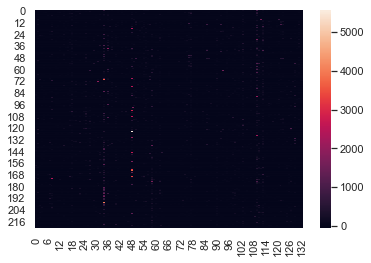

In [30]:
sns.set_theme()
ax = sns.heatmap(A_centered)

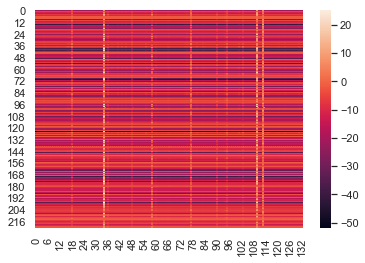

In [12]:
ax = sns.heatmap(L)

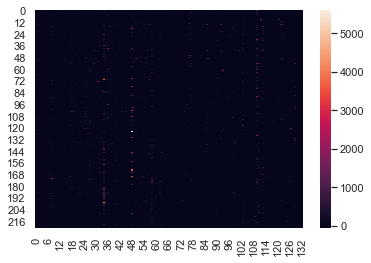

In [13]:
ax = sns.heatmap(S)

In [15]:
rpca_outliers = R_pca(A_outliers_centered)
L_outliers, S_outliers = rpca_outliers.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 85.34184938298645
iteration: 100, error: 1.107171527045505
iteration: 200, error: 1.4298707190813493
iteration: 300, error: 1.9775811265040855
iteration: 400, error: 2.74201321250682
iteration: 500, error: 2.811800454678788
iteration: 600, error: 2.4577775605814813
iteration: 700, error: 2.520349094205022
iteration: 800, error: 3.088609542750227
iteration: 900, error: 4.042915031057667
iteration: 1000, error: 4.134718124671718
iteration: 1100, error: 3.033045507186322
iteration: 1200, error: 2.6507938608168717
iteration: 1300, error: 2.6756367778451406
iteration: 1400, error: 2.461352557049528
iteration: 1500, error: 1.9394388090075223
iteration: 1600, error: 1.406304554593607
iteration: 1700, error: 0.5852500903526376
iteration: 1800, error: 0.4512131663648036
iteration: 1900, error: 0.3771829473868929
iteration: 2000, error: 0.18714624762226614
iteration: 2100, error: 0.1352194101970479
iteration: 2200, error: 0.1881652106271011
iteration: 2300, error: 0.29945347

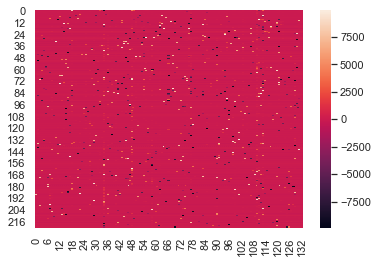

In [16]:
sns.set_theme()
ax = sns.heatmap(A_outliers_centered)

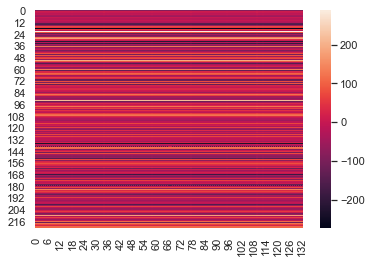

In [17]:
sns.set_theme()
ax = sns.heatmap(L_outliers)

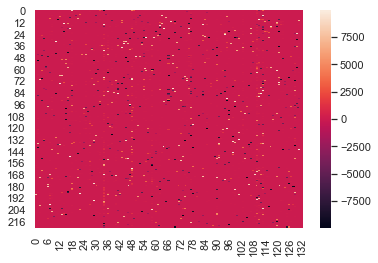

In [18]:
sns.set_theme()
ax = sns.heatmap(S_outliers)

In [19]:
def calc_rmse(coords, A_filled):
    total_error = 0
    for coord in coords:
        i, j = coord[0], coord[1]
        hours_pred = A_filled[i, j]
        hours_true = test_coords[coord]
        total_error += (hours_pred - hours_true)**2
        # print(hours_pred, hours_true)
    RMSE = np.sqrt(total_error / len(coords))
    return RMSE

In [20]:
calc_rmse(test_coords.keys(), L + A_mean)

316.98786412504285

In [21]:
calc_rmse(test_coords.keys(), L_outliers + A_outliers_mean)

317.8592766517595

### matrix_completion

- NuclearNorm
- Probabilistic Matrix Factorization with ALS

In [22]:
# % of values present
sum(sum(B))/(B.shape[0]*B.shape[1])

0.24286051451498702

In [23]:
m = 1/np.sqrt(max(A_centered.shape))
R_hat = mc.nuclear_norm_solve(A_centered, B, mu=m)

In [24]:
m = 1/np.sqrt(max(A_outliers_centered.shape))
R_outliers_hat = mc.nuclear_norm_solve(A_outliers_centered, B, mu=m)

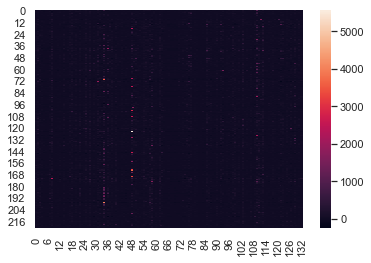

In [25]:
sns.heatmap(R_hat)

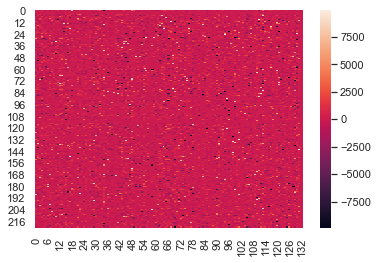

In [26]:
sns.heatmap(R_outliers_hat)

In [27]:
calc_rmse(test_coords.keys(), R_hat + A_mean)

302.10178517042016

In [28]:
calc_rmse(test_coords.keys(), R_outliers_hat + A_outliers_mean)

905.0282907277609

In [46]:
A_centered[B==0]=np.nan
R_knn = KNN(k=3).fit_transform(A_centered)

Imputing row 1/223 with 77 missing, elapsed time: 0.039
Imputing row 101/223 with 102 missing, elapsed time: 0.140
Imputing row 201/223 with 98 missing, elapsed time: 0.250


In [47]:
calc_rmse(test_coords.keys(), R_knn + A_mean)

307.66586318765286

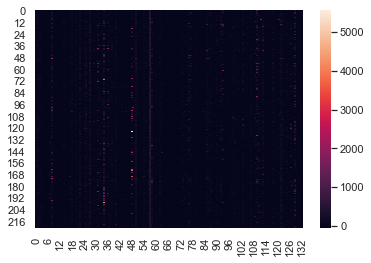

In [48]:
sns.heatmap(R_knn)

In [49]:
A_centered-S

array([[         nan,  20.20827068,          nan, ..., -20.39172932,
          4.20827068,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
         29.70902256,          nan],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,  -5.73909774,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,  17.80601504, ...,          nan,
                 nan,          nan]])